# **Multilayer Perceptron**

This notebook walks through the full process of training and evaluating a neural network (MLP) model to classify phage genes based on their expression timing. We used a leave-one-group-out cross-validation approach to test how well the model generalizes across different experimental datasets.

The workflow:

- Preprocessing the data with imputation (for missing values), standard scaling, and label encoding  
- Handling class imbalance using weighted loss during training  
- Training the model with early stopping to avoid overfitting  
- Evaluating model performance using accuracy, macro F1 score, and both raw and normalized confusion matrices  
- Final testing on the combined dataset to see how well the model performs overall

Below there is the code used to train the model on each split, evaluate results, and summarize performance.


In [24]:
import os
import random
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import joblib
import pickle


=== Split 0 – Group: Brandao_MCCM_feature_table.tsv ===
              precision    recall  f1-score   support

       early       0.18      0.67      0.29         3
        late       0.67      0.31      0.43        32
      middle       0.32      0.47      0.38        19

    accuracy                           0.39        54
   macro avg       0.39      0.48      0.36        54
weighted avg       0.52      0.39      0.40        54



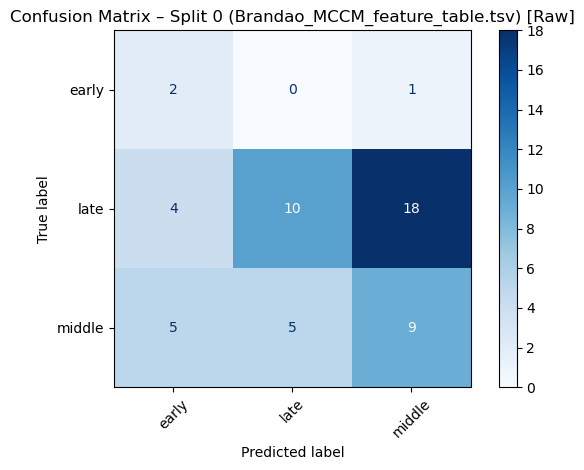

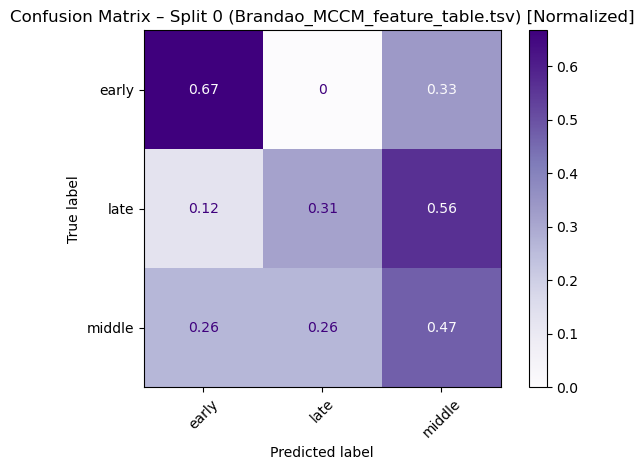


=== Split 1 – Group: Finstrlova_Newman_feature_table.tsv ===
              precision    recall  f1-score   support

       early       0.32      0.13      0.18        78
        late       0.29      0.76      0.42        59
      middle       0.43      0.21      0.28       100

    accuracy                           0.32       237
   macro avg       0.35      0.37      0.29       237
weighted avg       0.36      0.32      0.28       237



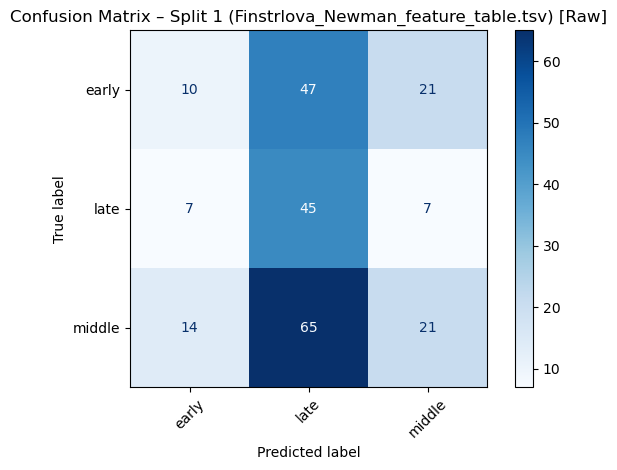

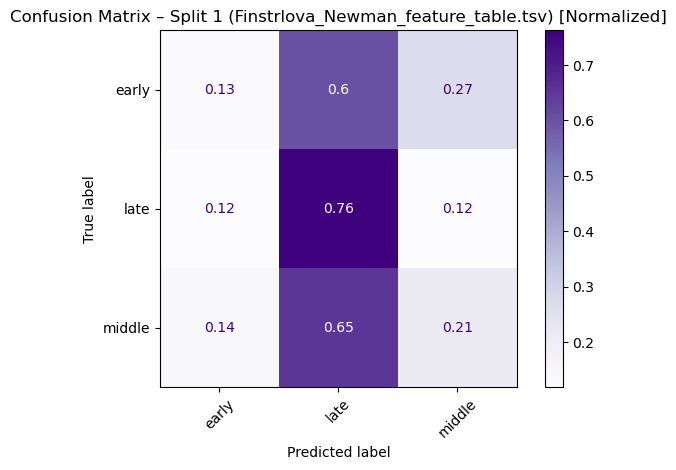


=== Split 2 – Group: Guegler_T4_minusToxIN_feature_table.tsv ===
              precision    recall  f1-score   support

       early       0.66      0.26      0.37       162
        late       0.50      0.68      0.58       117
      middle       0.05      0.33      0.08         9

    accuracy                           0.43       288
   macro avg       0.40      0.43      0.34       288
weighted avg       0.57      0.43      0.45       288



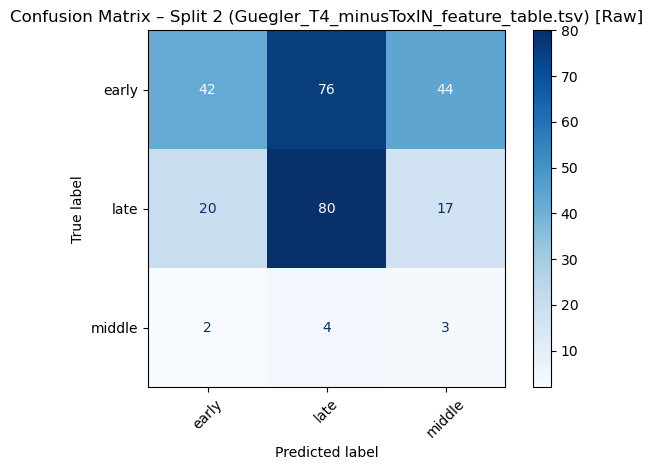

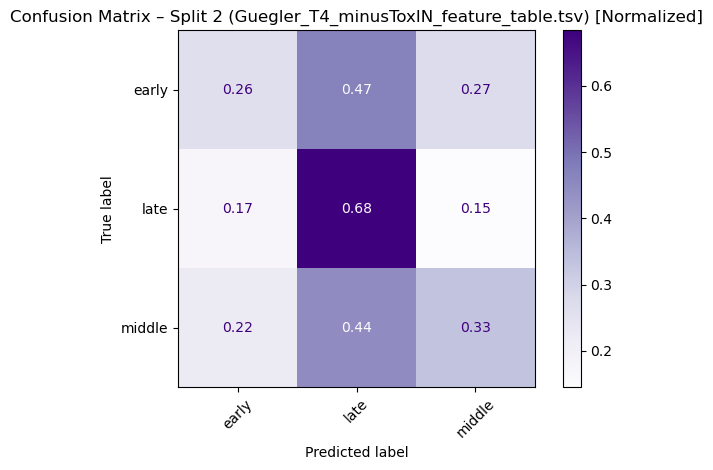


=== Split 3 – Group: Guegler_T7_plusToxIN_feature_table.tsv ===
              precision    recall  f1-score   support

       early       0.19      0.57      0.29         7
        late       0.54      0.71      0.61        21
      middle       0.64      0.22      0.33        32

    accuracy                           0.43        60
   macro avg       0.45      0.50      0.41        60
weighted avg       0.55      0.43      0.42        60



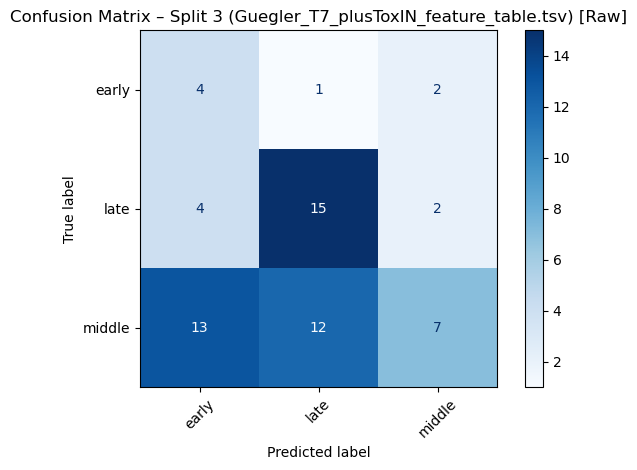

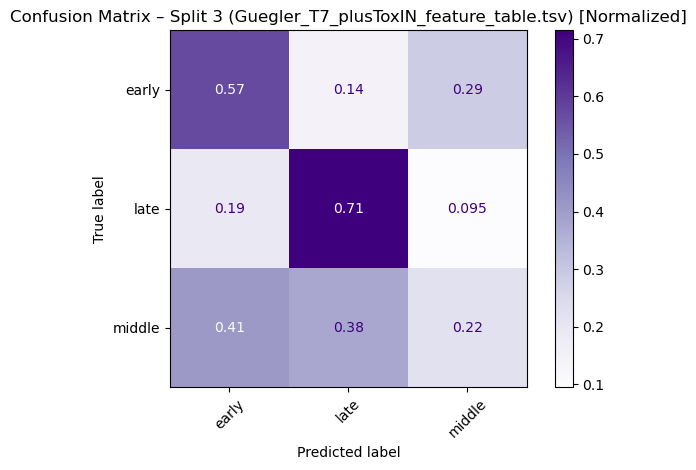


=== Split 4 – Group: Lood_feature_table.tsv ===
              precision    recall  f1-score   support

       early       0.11      0.50      0.18        46
        late       0.60      0.65      0.62       209
      middle       0.61      0.08      0.15       206

    accuracy                           0.38       461
   macro avg       0.44      0.41      0.32       461
weighted avg       0.55      0.38      0.37       461



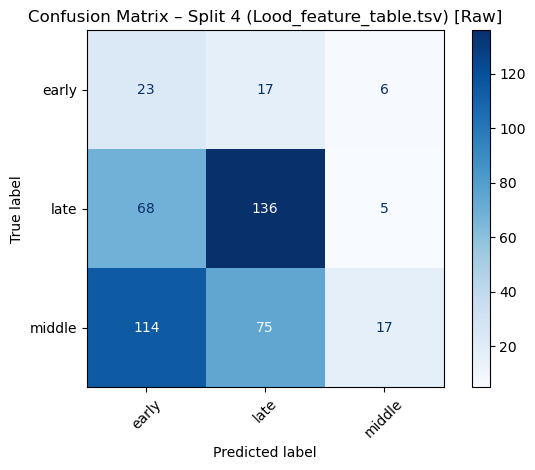

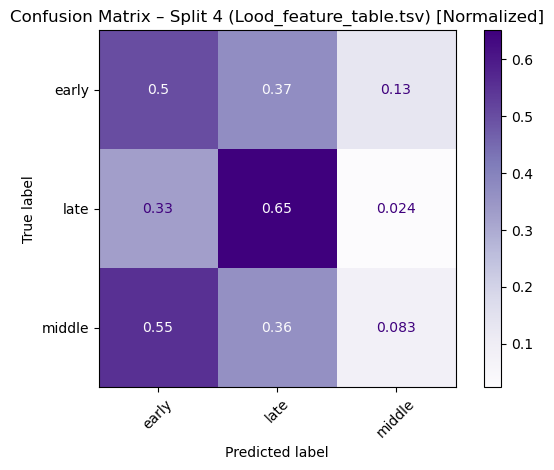


=== Split 5 – Group: Yang_feature_table.tsv ===
              precision    recall  f1-score   support

       early       0.24      0.78      0.37         9
        late       0.86      0.52      0.65        23
      middle       0.45      0.23      0.30        22

    accuracy                           0.44        54
   macro avg       0.52      0.51      0.44        54
weighted avg       0.59      0.44      0.46        54



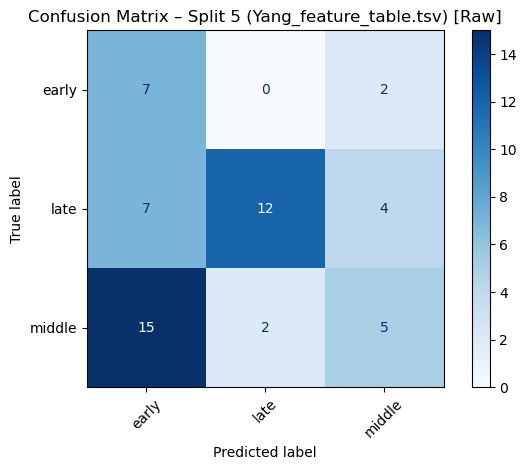

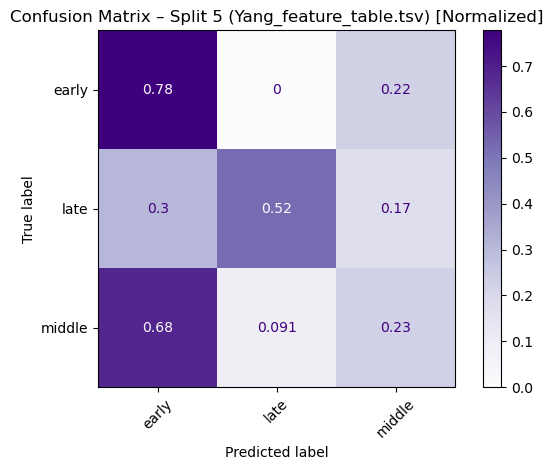


=== Final Test on combined.tsv ===
              precision    recall  f1-score   support

       early       0.83      0.97      0.89       305
        late       0.94      0.85      0.89       461
      middle       0.89      0.87      0.88       388

    accuracy                           0.89      1154
   macro avg       0.89      0.90      0.89      1154
weighted avg       0.89      0.89      0.89      1154

Accuracy (combined): 0.8882149046793761


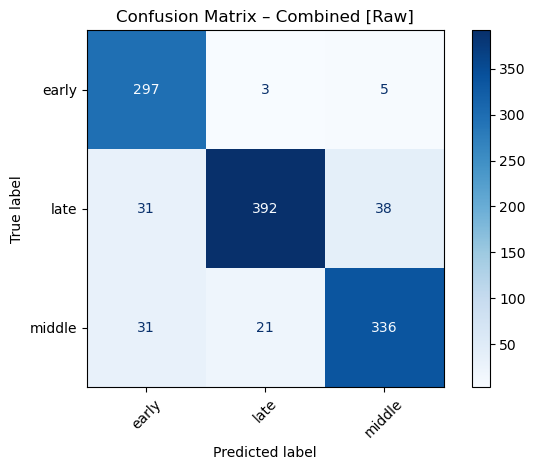

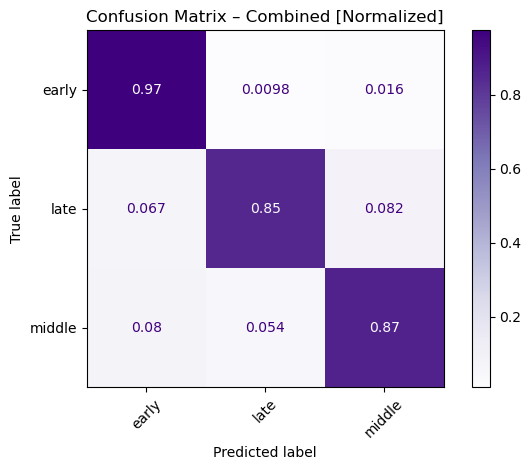

,Split,Group,Accuracy,Macro F1
0,Split 0,Brandao_MCCM_feature_table.tsv,0.388889,0.364742
1,Split 1,Finstrlova_Newman_feature_table.tsv,0.320675,0.294011
2,Split 2,Guegler_T4_minusToxIN_feature_table.tsv,0.434028,0.343830
3,Split 3,Guegler_T7_plusToxIN_feature_table.tsv,0.433333,0.407847
4,Split 4,Lood_feature_table.tsv,0.381779,0.316997
5,Split 5,Yang_feature_table.tsv,0.444444,0.440033
6,Combined,All,0.888215,0.888225


In [28]:
# Ensure reproducibility by setting seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# General configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
BATCH_SIZE = 64
PATIENCE = 10
DATA_DIR = "../data/leave-one-group-out-split/splits"


# Load combined dataset and define feature columns
combined = pd.read_csv("../data/leave-one-group-out-split/combined.tsv", sep="\t")
drop_cols = ["Unnamed: 0", "Geneid", "DNASequence", "group", "classification_x"]
feature_cols = [c for c in combined.columns if c not in drop_cols]

# Encode class labels as integers
le = LabelEncoder()
le.fit(combined["classification_x"])

# Define the MLP architecture
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.out = nn.Linear(64, num_classes)
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.drop(F.relu(self.fc3(x)))
        return self.out(x)

# Training loop with early stopping based on validation accuracy
def train_model(model, train_loader, val_loader, criterion, optimizer):
    best_acc = 0
    patience_counter = 0
    best_model = None
    for epoch in range(EPOCHS):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(DEVICE), y_val.to(DEVICE)
                preds = model(X_val).argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(y_val.cpu().numpy())
        acc = accuracy_score(all_targets, all_preds)
        if acc > best_acc:
            best_acc = acc
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= PATIENCE:
            break
    if best_model is not None:
        model.load_state_dict(best_model)
    return model

# Store evaluation results for all splits
results = []

# Loop through all leave-one-group-out splits
for split in range(6):
    train_df = pd.read_csv(f"{DATA_DIR}/train_split_{split}.tsv", sep="\t")
    test_df = pd.read_csv(f"{DATA_DIR}/test_split_{split}.tsv", sep="\t")
    group_name = test_df["group"].iloc[0]

    # Prepare features and labels
    y_train = le.transform(train_df["classification_x"])
    y_test = le.transform(test_df["classification_x"])
    X_train = train_df[feature_cols]
    X_test = test_df[feature_cols]

    # Impute missing values and scale features
    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create data loaders
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE)

    # Initialize model, loss, and optimizer
    model = MLP(input_dim=X_train.shape[1], num_classes=len(le.classes_)).to(DEVICE)
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(DEVICE))
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # Train model
    model = train_model(model, train_loader, val_loader, criterion, optimizer)

    # Predict and evaluate
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor.to(DEVICE)).argmax(dim=1).cpu().numpy()

    print(f"\n=== Split {split} – Group: {group_name} ===")
    print(classification_report(y_test, preds, target_names=le.classes_))

    # Raw confusion matrix
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Confusion Matrix – Split {split} ({group_name}) [Raw]")
    plt.tight_layout()
    plt.show()

    # Normalized confusion matrix
    cm_norm = confusion_matrix(y_test, preds, normalize="true")
    ConfusionMatrixDisplay(cm_norm, display_labels=le.classes_).plot(cmap="Purples", xticks_rotation=45)
    plt.title(f"Confusion Matrix – Split {split} ({group_name}) [Normalized]")
    plt.tight_layout()
    plt.show()

    # Save model state dict and data for later comparison
    model_dir = f"../data/mlp"
    os.makedirs(model_dir, exist_ok=True)

    # Save only the state dict (not the full object)
    torch.save(model.state_dict(), os.path.join(model_dir, f"model_split_{split}.pt"))

    # Save associated data
    with open(os.path.join(model_dir, f"split_{split}_data.pkl"), "wb") as f:
        pickle.dump((X_train, y_train, X_test, y_test, le, feature_cols), f)


    # Save metrics
    report = classification_report(y_test, preds, output_dict=True, zero_division=0)
    acc = accuracy_score(y_test, preds)
    results.append({
        "Split": f"Split {split}",
        "Group": group_name,
        "Accuracy": acc,
        "Macro F1": report["macro avg"]["f1-score"]
    })


# Final evaluation on the full combined dataset
print("\n=== Final Test on combined.tsv ===")
combined_df = pd.read_csv("../data/leave-one-group-out-split/combined.tsv", sep="\t")
combined_df = combined_df[combined_df["classification_x"].isin(le.classes_)]
X_combined = combined_df[feature_cols]
y_combined = le.transform(combined_df["classification_x"])
X_combined = imputer.transform(X_combined)
X_combined = scaler.transform(X_combined)
X_combined_tensor = torch.tensor(X_combined, dtype=torch.float32).to(DEVICE)

model.eval()
with torch.no_grad():
    y_pred_combined = model(X_combined_tensor).argmax(dim=1).cpu().numpy()

print(classification_report(y_combined, y_pred_combined, target_names=le.classes_))
print("Accuracy (combined):", accuracy_score(y_combined, y_pred_combined))

# Confusion matrix on combined data
cm = confusion_matrix(y_combined, y_pred_combined)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix – Combined [Raw]")
plt.tight_layout()
plt.show()

cm_norm = confusion_matrix(y_combined, y_pred_combined, normalize="true")
ConfusionMatrixDisplay(cm_norm, display_labels=le.classes_).plot(cmap="Purples", xticks_rotation=45)
plt.title("Confusion Matrix – Combined [Normalized]")
plt.tight_layout()
plt.show()

# Save final combined results
report_comb = classification_report(y_combined, y_pred_combined, output_dict=True, zero_division=0)
acc_comb = accuracy_score(y_combined, y_pred_combined)
results.append({
    "Split": "Combined",
    "Group": "All",
    "Accuracy": acc_comb,
    "Macro F1": report_comb["macro avg"]["f1-score"]
})

# Display summary table
summary_df = pd.DataFrame(results)
display(summary_df)

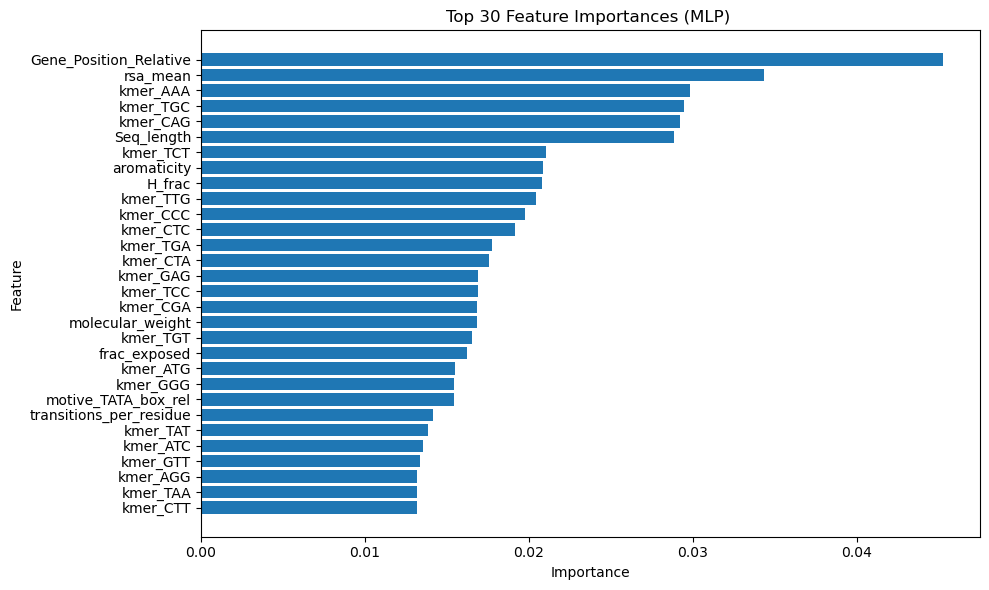

In [22]:
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt

# ✅ Custom sklearn-compatible wrapper for the PyTorch MLP model
class TorchMLPWrapper(BaseEstimator):
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def fit(self, X, y):
        # Dummy fit to satisfy sklearn interface
        return self

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            preds = self.model(X_tensor).argmax(dim=1).cpu().numpy()
        return preds

# Wrap the trained model
wrapped_model = TorchMLPWrapper(model=model, device=DEVICE)

# Run permutation importance
result = permutation_importance(
    wrapped_model,
    X_combined,
    y_combined,
    scoring="accuracy",
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# 📊 Plot top 30 features
importances = result.importances_mean
indices = np.argsort(importances)[::-1][:30]
top_features = [feature_cols[i] for i in indices]
top_importances = importances[indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], top_importances[::-1])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 30 Feature Importances (MLP) ")
plt.tight_layout()
plt.show()


### Testing on the Stratified Split

- Loads the stratified train/test sets.
- Applies the same preprocessing as your other splits.
- Trains a fresh MLP model on the stratified training data.
- Evaluates and prints a classification report.
- Shows both a raw and normalized confusion matrix.


=== Evaluation on Stratified Split ===
              precision    recall  f1-score   support

       early       0.84      0.84      0.84        61
        late       0.89      0.90      0.90        92
      middle       0.88      0.87      0.88        78

    accuracy                           0.87       231
   macro avg       0.87      0.87      0.87       231
weighted avg       0.87      0.87      0.87       231

Accuracy (stratified): 0.8744588744588745


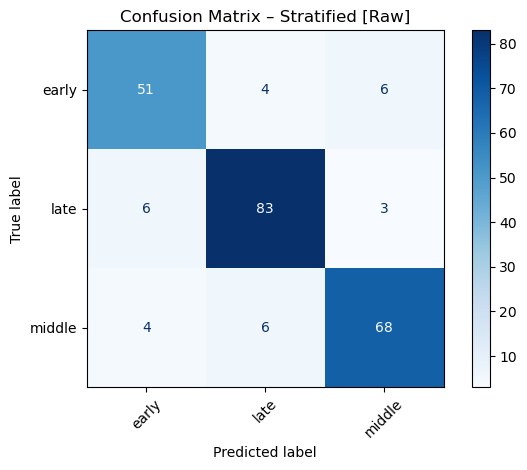

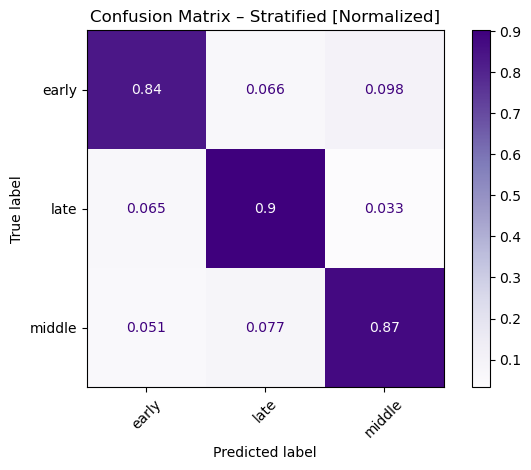

In [30]:
# Evaluation on Stratified Split ===
print("\n=== Evaluation on Stratified Split ===")

# Load stratified split data
train_strat = pd.read_csv("../data/combined-data-stratified-split/train_data.tsv", sep="\t")
test_strat = pd.read_csv("../data/combined-data-stratified-split/test_data.tsv", sep="\t")

# Preprocess features and labels
y_train_strat = le.transform(train_strat["classification_x"])
y_test_strat = le.transform(test_strat["classification_x"])
X_train_strat = train_strat[feature_cols]
X_test_strat = test_strat[feature_cols]

# Impute and scale
X_train_strat = imputer.fit_transform(X_train_strat)
X_test_strat = imputer.transform(X_test_strat)
X_train_strat = scaler.fit_transform(X_train_strat)
X_test_strat = scaler.transform(X_test_strat)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_strat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_strat, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_strat, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_strat, dtype=torch.long)

# Train model from scratch on stratified data
model_strat = MLP(input_dim=X_train_tensor.shape[1], num_classes=len(le.classes_)).to(DEVICE)
class_weights_strat = compute_class_weight("balanced", classes=np.unique(y_train_strat), y=y_train_strat)
criterion_strat = nn.CrossEntropyLoss(weight=torch.tensor(class_weights_strat, dtype=torch.float32).to(DEVICE))
optimizer_strat = torch.optim.AdamW(model_strat.parameters(), lr=1e-3, weight_decay=1e-4)

train_loader_strat = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)
val_loader_strat = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE)

# Train
model_strat = train_model(model_strat, train_loader_strat, val_loader_strat, criterion_strat, optimizer_strat)

# Evaluate
model_strat.eval()
with torch.no_grad():
    preds_strat = model_strat(X_test_tensor.to(DEVICE)).argmax(dim=1).cpu().numpy()

# Report
print(classification_report(y_test_strat, preds_strat, target_names=le.classes_))
print("Accuracy (stratified):", accuracy_score(y_test_strat, preds_strat))

# Raw confusion matrix
cm = confusion_matrix(y_test_strat, preds_strat)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix – Stratified [Raw]")
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_norm = confusion_matrix(y_test_strat, preds_strat, normalize="true")
ConfusionMatrixDisplay(cm_norm, display_labels=le.classes_).plot(cmap="Purples", xticks_rotation=45)
plt.title("Confusion Matrix – Stratified [Normalized]")
plt.tight_layout()
plt.show()

# Save stratified model and data
model_dir_strat = "../data/mlp"
os.makedirs(model_dir_strat, exist_ok=True)

# Save as split 6
torch.save(model_strat.state_dict(), os.path.join(model_dir_strat, "model_split_6.pt"))

with open(os.path.join(model_dir_strat, "split_6_data.pkl"), "wb") as f:
    pickle.dump((X_train_strat, y_train_strat, X_test_strat, y_test_strat, le, feature_cols), f)
